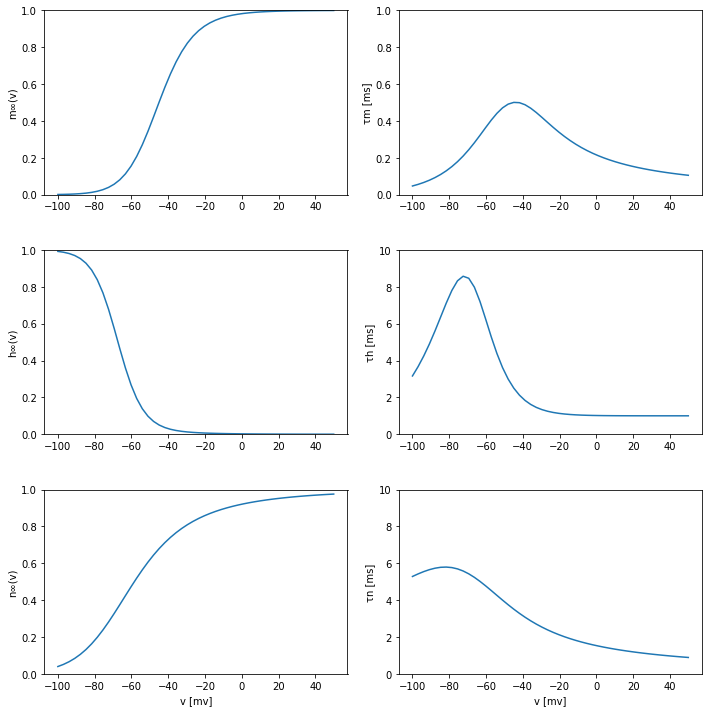

In [53]:
import numpy as np
import matplotlib.pyplot as plt

def alpha_m(v):
    return ((v+45)/10)/(1-np.exp(-(v+45)/10))
def beta_m(v):
    return 4*np.exp(-(v+70)/18)
    
def alpha_h(v):
    return 0.07*np.exp(-(v+70)/20)
def beta_h(v):
    return 1/(np.exp(-(v+40)/10)+1)
    
def alpha_n(v): 
    return 1/100 * (v+60)/(1-np.exp(-(v+60)/10))
def beta_n(v):
    return 1/8 * np.exp(-(v+70)/80)

v = np.linspace(-100,50)
def m_inf(v=0.0):
    return alpha_m(v)/(alpha_m(v)+beta_m(v))
    #return 1.0/(1.0+ (np.exp((v+25.5)/(-5.29))))
def m_tau(v=0.0):
    return 1/(alpha_m(v)+beta_m(v))
    #return (2.64 - 2.52/(1.0+ (np.exp((v+120)/(-25)))))

def h_inf(v=0.0):
    return alpha_h(v)/(alpha_h(v)+beta_h(v))
    #return 1.0/(1.0+ (np.exp((v+48.9)/(5.18))))  
def h_tau(v=0.0):
    return 1/(alpha_h(v)+beta_h(v))
    #return (1.34/(1+ (np.exp((v+62.9)/(-10)))))*(1.5 + 1.0/(1.0 + (np.exp((v+34.9)/(3.6)))))

def n_inf(v=0.0):
    return alpha_n(v)/(alpha_n(v)+beta_n(v))
    #return 1.0/(1.0 + (np.exp((v+12.3)/(-11.8))))
def n_tau(v=0.0):
    return 1/(alpha_n(v)+beta_n(v))
    #return 14.4 - 12.8/(1.0+(np.exp((v+28.3)/(-19.2))))

#m_inf = 1.0/(1.0+ (np.exp((v+25.5)/(-5.29))))
#m_tau = (2.64 - 2.52/(1.0+ (np.exp((v+120)/(-25)))))
#h_inf = 1.0/(1.0+ (np.exp((v+48.9)/(5.18))))  
#h_tau = (1.34/(1+ (np.exp((v+62.9)/(-10)))))*(1.5 + 1.0/(1.0 + (np.exp((v+34.9)/(3.6)))))
#n_inf = 1.0/(1.0 + (np.exp((v+12.3)/(-11.8))))
#n_tau = 14.4 - 12.8/(1.0+(np.exp((v+28.3)/(-19.2))))

f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(10,10))

ax1.plot(v,m_inf(v))
ax1.set_ylim([0, 1])
ax1.set(ylabel='m∞(v)')
ax2.plot(v,m_tau(v))
ax2.set_ylim([0, 1])
ax2.set(ylabel='τm [ms]')

ax3.plot(v,h_inf(v))
ax3.set_ylim([0, 1])
ax3.set(ylabel='h∞(v)')
ax4.plot(v,h_tau(v))
ax4.set_ylim([0, 10])
ax4.set(ylabel='τh [ms]')

ax5.plot(v,n_inf(v))
ax5.set_ylim([0, 1])
ax5.set(ylabel='n∞(v)',xlabel='v [mv]')
ax6.plot(v,n_tau(v))
ax6.set_ylim([0, 10])
ax6.set(ylabel='τn [ms]',xlabel='v [mv]')

plt.tight_layout()
f.subplots_adjust(hspace=0.3)

In [54]:
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from ipywidgets import interactive

def plot_hh(C = 1, vNa = 45, vK = -82, vL = -59,
            gNa = 120, gK = 36, gL = 0.3, v_init = -65,
            inj_amp = 10, inj_start = 50, inj_dur = 20,
            tmin=0, tmax=100):

    def I(t,amp,start,dur):
        return np.piecewise(t, [t<start, t>=start, t>=start+dur], [0,amp,0])

    def hh_eq(y,t,inj_amp,inj_start,inj_dur):
        dy = np.zeros((8,))

        Vm = y[0]
        m = y[1]
        h = y[2]
        n = y[3]

        i_Na = gNa*np.power(m,3)*h*(vNa - Vm)
        i_K =  gK*np.power(n,4)*(vK - Vm)
        i_L =  gL*(vL - Vm)

        dy[0] = (i_Na + i_K + i_L + I(t,inj_amp,inj_start,inj_dur))/C
        dy[1] = (alpha_m(Vm) * (1.0 - m)) - (beta_m(Vm) * m)
        dy[2] = (alpha_h(Vm) * (1.0 - h)) - (beta_h(Vm) * h)
        dy[3] = (alpha_n(Vm) * (1.0 - n)) - (beta_n(Vm) * n)
        
        # Convienient way of saving conductances
        dy[4] = i_Na - y[4]
        dy[5] = i_K - y[5]
        dy[6] = i_L - y[6]
        # Save the timestamps
        dy[7] = t - y[7]
        return dy

    t = np.linspace(tmin, tmax, 1000)
    Y = np.array([v_init, n_inf(), m_inf(), h_inf(), 0, 0, 0, 0])
    v = odeint(hh_eq,Y,t,args=(inj_amp,inj_start,inj_dur))
    
    f, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(12,12))
    ax1.plot(t,v[:,0])
    ax1.set(ylabel='v [mv]',xlabel='time [ms]')
    ax1.set_title('Cell Potential')
    
    ax2.plot(t,v[:,1])
    ax2.plot(t,v[:,2])
    ax2.plot(t,v[:,3])
    ax2.set(ylabel='Probability',xlabel='time [ms]')
    ax2.legend(["m","h","n"])
    ax2.set_title('Gate Activation/Inactivation')
    
    ax3.plot(t,v[:,4])
    ax3.plot(t,v[:,5])
    ax3.plot(t,v[:,6])
    ax3.set(ylabel='Conductance [mS/cm2]',xlabel='time [ms]')
    ax3.legend(["Na","K","Leak"])
    ax3.set_title('Channel Conductance')
    
    ax4.plot(t,I(t,inj_amp,inj_start,inj_dur))
    ax4.set(ylabel='Current [nA]',xlabel='time [ms]')
    ax4.set_title('Current Injection')
    
    plt.tight_layout()
    f.subplots_adjust(hspace=0.3)  
    
    # limit cycles
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.plot(v[:, 0], v[:, 1], label='Vm - m')
    ax.plot(v[:, 0], v[:, 3], label='Vm - n')
    ax.set_title('Limit cycles')
    ax.legend()
    plt.grid()

interactive(plot_hh,C=(1,10,.5),vNa =(-100,100,1), vK = (-100,100,1), vL = (-100,100,1), gNa = (0,200,1), gK = (0,200,1), gL = (0,10,.1), v_init = (-100,100,1), inj_amp = (0,100,1), inj_start = (0,1000,10), inj_dur = (0,1000,10), tmin=(0,1000,10),tmax=(0,1000,10))

interactive(children=(FloatSlider(value=1.0, description='C', max=10.0, min=1.0, step=0.5), IntSlider(value=45…